In [261]:
#import all the things
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from PIL import Image
from PIL import ImageStat
from matplotlib.pyplot import imshow
import numpy as np
import fnmatch
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import pandas as pd
%matplotlib inline

In [262]:
#connect to database
dbname = 'coffee_detai1'
username = 'emclinden'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

# con = None
# con = psycopg2.connect(database = dbname, user = username)

postgres://emclinden@localhost/coffee_detai1


In [38]:
# query picture addresses:


In [263]:
#Eeep, there are some duplicates due to data being gathered
#over multiple days and picture being pushed to new pages
#likes/views/comments can change so keep last instance:
sql_query = """
SELECT * FROM image_address;
"""

data = pd.read_sql_query(sql_query,engine)
ndf = data.drop_duplicates('picture_id',keep='last')
ndf.to_sql('image_address', engine, if_exists='replace')

In [264]:
#same as cell above for other table
sql_query = """
SELECT * FROM image_stats;
"""

data = pd.read_sql_query(sql_query,engine)
ndf = data.drop_duplicates('picture_id',keep='last')
ndf.to_sql('image_stats', engine, if_exists='replace')

In [265]:
#ok, now that sql tables are cleaned up let's get on with processing
sql_query = """
SELECT * FROM image_address;
"""

data = pd.read_sql_query(sql_query,engine)

In [267]:
#resize all the images to 50px x 50px and save
#add column to df that includes new file name
#update the sql db
nsave = []
for d in data.picture_address:
    img = Image.open(d,'r')
    new_img = img.resize((50,50)) #which is fine but need to make a try/except in later loop that unrolls
    new_name = '/Users/emclinden/coffee_100115_011816/s50_'+ d.split('011816/')[1]
    #new_img.save(new_name,'jpeg')
    nsave.append(new_name)


In [ ]:
n = data.drop('index', axis=1)
b = n.drop('level_0',axis=1)

In [272]:
b['small_address'] = nsave

In [274]:
b.to_sql('image_address', engine, if_exists='replace')

In [ ]:
#now figure out some quantitative features 
#for each image and add those to the df then save to sql

In [275]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

In [276]:
#http://stackoverflow.com/questions/3490727/what-are-some-methods-to-analyze-image-brightness-using-python
def brightness( im_file ):
   im = Image.open(im_file).convert('L')
   stat = ImageStat.Stat(im)
   return stat.rms[0]

In [ ]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
n_colors = 8 #will reduce images to 8-color images

#get the images from which you are going to get dominant colors 
sql_query = """
SELECT small_address FROM image_address;
"""
data = pd.read_sql_query(sql_query,engine)

In [92]:
# for pim in data.small_address:
#     img = Image.open(pim,'r')
#     print np.shape(np.asarray(img))


# img = np.array(img, dtype=np.float64) / 255
# w, h, d = original_shape = tuple(img.shape)
# image_array = np.reshape(img, (w * h, d))
i = 0
# for pim in data.small_address:
#     img = Image.open(pim,'r')
#     if np.shape(np.asarray(img)) != (50,50,3):
#         print 'not', i
#     i = i+1
    
# pim = data.small_address[585]
# img = Image.open(pim,'r')
# print np.shape(np.asarray(img))
# img = np.array(img, dtype=np.float64) / 255
# w,h,d
# image_array = np.reshape(img, (w * h, 1))
# np.shape(image_array)

In [280]:
#this cell is the meat - calculate some image features for each image in tables

bright = [] #empty list to hold brightness values
contrast = [] #empty list to hold contrast values
hexcolor = [] #empty list to hold hex colors (each is list of 8 hex colors)
i = 0
for pim in data.small_address:
    img = Image.open(pim,'r')
    img = np.array(img, dtype=np.float64) / 255
    if np.shape(np.asarray(img)) == (50,50,3):
        w, h, d = original_shape = tuple(img.shape)
        assert d == 3
        #unroll img into image_array
        image_array = np.reshape(img, (w * h, d))
 
        #Fit model on a small sub-sample of the data
        image_array_sample = shuffle(image_array, random_state=0)[:1000]
        kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

        #Predict color indices on the full image (via k-means)
        labels = kmeans.predict(image_array)
        kc =kmeans.cluster_centers_ *255
        hexc = []
        for k in kc:
            hexc.append('#%02x%02x%02x' % (k[0],   k[1],   k[2]))
        hexcolor.append(hexc) #store hexcolor

        bright.append(brightness(pim)) #store brightness

        gimg = Image.open(pim,'r').convert('L')
        gim = np.ravel(gimg)
        hist,bins = np.histogram(gim,255,[0,255])
        itemindex = np.where((hist > 10) == True)
        contrast.append(itemindex[0][-1] - itemindex[0][0]) #store contrast
        print i
    #for now I'm skipping B&W
    else:
        bright.append('None')
        hexcolor.append('None')
        contrast.append('None')
        print i, 'None'
    i = i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [281]:
#read image_stats because we want to append few columns
sql_query = """
SELECT * FROM image_stats;
"""
data2 = pd.read_sql_query(sql_query,engine)

In [ ]:
#append columns
data2['hexcolors'] = hexcolor
data2['brightness'] = bright
data2['contrast'] = contrast

In [ ]:
dd = data2.drop('level_0',axis=1)

In [291]:
#send to db
dd.to_sql('image_stats', engine, if_exists='replace')

In [ ]:
dd = dd[dd.brightness != 'None']
#df = df[df.line_race != 0]

In [ ]:
dd.to_sql('image_stats_del', engine, if_exists='replace')

In [ ]:
sql_query = """
SELECT * FROM image_address;
"""
data2 = pd.read_sql_query(sql_query,engine)

In [300]:
data2.picture_id[585],data2.picture_id[3537],data2.picture_id[3664]

(u'8720928528', u'716835908', u'22228781712')

In [ ]:
data2 = data2[data2.picture_id != '8720928528']

In [ ]:
data2 = data2[data2.picture_id != '716835908']

In [ ]:
data2 = data2[data2.picture_id != '22228781712']

In [305]:
data2.to_sql('image_address_del', engine, if_exists='replace')

In [308]:
sql_query = """
SELECT * FROM image_stats_del;
"""
data = pd.read_sql_query(sql_query,engine)

In [ ]:
#this section is only if you to view image
# def recreate_image(codebook, labels, w, h):
#     """Recreate the (compressed) image from the code book & labels"""
#     d = codebook.shape[1]
#     image = np.zeros((w, h, d))
#     label_idx = 0
#     for i in range(w):
#         for j in range(h):
#             image[i][j] = codebook[labels[label_idx]]
#             label_idx += 1
#     return image

# plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

(-100, 10000)

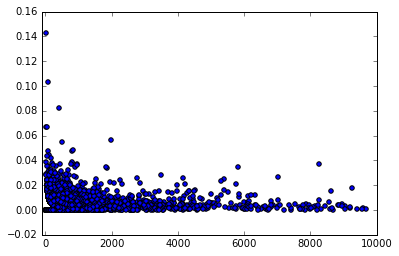

In [129]:
y = data.n_favs.astype('float') / data.n_views.astype('float')
x = data.n_views.astype('float')
plt.scatter(x,y,s=20)
plt.xlim([-100,10000])

(0, 300)

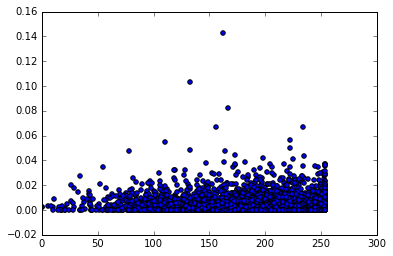

In [151]:
c = np.asarray(data.contrast).astype('int').astype('float')
plt.scatter(c,y)
plt.xlim([0,300])

In [315]:
len(data.brightness)
# bright = []

# for f in b:
#     try:
#         a = float(f)
#         bright.append(a)
#     except:
#         a = -100
#         bright.append(a)



3865

254

In [ ]:
ncomm = data.n_comments.astype('int').astype('float')

In [ ]:
tags = data.tag_text
ntags = []
for t in tags:
    t = t.replace('{','')
    t = t.replace('}','')
    a = t.split(",")
    ntags.append(len(a))

In [239]:
data.drop('brightness',axis=1)
data['brightness'] = bright

In [240]:
data.drop('contrast',axis=1)
data['contrast'] = contr

In [ ]:
data['ntags'] = ntags

In [242]:
data['ncomments'] = ncomm

In [ ]:
d = data.drop('level_0',axis=1)

In [ ]:
d = d.drop('index',axis=1)

In [328]:
d.to_sql('image_stats_del', engine, if_exists='replace')

,picture_id,user_id,static_file,date_posted,n_favs,n_views,n_comments,tag_raw,tag_text,latitude,longitude,hexcolors,brightness,contrast,ntags
0,6676961391,7891351@N05,https://farm8.staticflickr.com/7146/6676961391...,1326255301,0,232,2,{coffee},{coffee},40.717833,-73.959667,"{#8d8457,#ddd7b3,#21170b,#a39969,#f6f3db,#b7ad...",169.645785,231,1
1,15444712858,81650523@N04,https://farm6.staticflickr.com/5608/1544471285...,1414320368,11,4122,1,"{Coffee,Black,White,Cup,Mug,Mugg,Kaffe,Kaffemu...","{coffee,black,white,cup,mug,mugg,kaffe,kaffemu...",56.170503,14.860422,"{#37392e,#d0c8ad,#6f6e57,#1f221b,#ece5cb,#928d...",131.139414,217,14
2,15004931544,32157516@N05,https://farm4.staticflickr.com/3953/1500493154...,1414264980,23,2184,5,"{davide978,milano,milan,sempione,colazione,bre...","{davide978,milano,milan,sempione,colazione,bre...",45.478481,9.172918,"{#b7bbbd,#4e4638,#363328,#d8d9d7,#7f7e75,#9c9e...",140.740993,197,25
3,15600916982,56237114@N08,https://farm6.staticflickr.com/5608/1560091698...,1413982237,9,1818,1,"{Rijeka,hrvatska,croatia,summer,panorama,canon...","{rijeka,hrvatska,croatia,summer,panorama,canon...",45.332523,14.455518,"{#8b8b85,#22262c,#bee2f1,#11110e,#a8acab,#f7f1...",167.636340,240,20
4,15407506400,126314760@N06,https://farm6.staticflickr.com/5612/1540750640...,1413908972,1,180,0,"{travel,coffee,cafe,kaffe,relax,terrace}","{travel,coffee,cafe,kaffe,relax,terrace}",40.412777,-3.708572,"{#1b120e,#dad7d4,#83776a,#3d2e26,#ae9883,#9f6e...",134.482411,208,6
5,15397619317,8096730@N04,https://farm6.staticflickr.com/5606/1539761931...,1413816439,2,1173,0,"{Oregon,coffee,""Olympus OM-D E-M5"",E-M5,""Stump...","{oregon,coffee,olympusomdem5,em5,stumptowncoff...",45.522000,-122.681592,"{#0b0907,#908d7b,#9e5e1f,#f9d385,#6d6a5b,#422c...",96.351542,185,10
6,15186661968,69861074@N00,https://farm4.staticflickr.com/3850/1518666196...,1411854385,19,1199,5,"{lifestyle,cafe,DCist,Dolcezza,Mosaic,gibraltar}","{lifestyle,cafe,dcist,dolcezza,mosaic,gibraltar}",38.873025,-77.231278,"{#050505,#afafaf,#747474,#fbfbfb,#323232,#8d8d...",142.557619,254,6
7,15138977569,82684724@N00,https://farm4.staticflickr.com/3869/1513897756...,1411494024,17,2494,0,"{""Scout Coffee ~ San Luis Obispo, California"",...","{scoutcoffee~sanluisobispocalifornia,coffee,co...",35.279205,-120.663352,"{#331d11,#e6c0a6,#b0433f,#c28e72,#e3e5e8,#8729...",151.005344,211,10
8,15040731800,38501716@N08,https://farm4.staticflickr.com/3878/1504073180...,1410633692,53,3438,11,"{snack,casa,brown,dessert,niftyfifty,editadaco...","{snack,casa,brown,dessert,niftyfifty,editadaco...",19.322503,-99.133168,"{#775644,#3c1b0e,#bfb3a5,#5e3926,#a99585,#d6cf...",112.586799,207,47
9,15154582916,100016856@N08,https://farm6.staticflickr.com/5578/1515458291...,1410231364,136,5405,36,"{lunchbreak,break,breaking,icedcoffee,tea,frie...","{lunchbreak,break,breaking,icedcoffee,tea,frie...",35.005689,135.768912,"{#edc3a8,#654047,#191226,#a57f67,#9a5040,#c49f...",136.117523,193,20
